# Naive Bayes
- 2020-2 Artifitial Intelligence  
- week5 Assignment  
- Updated 1003
-

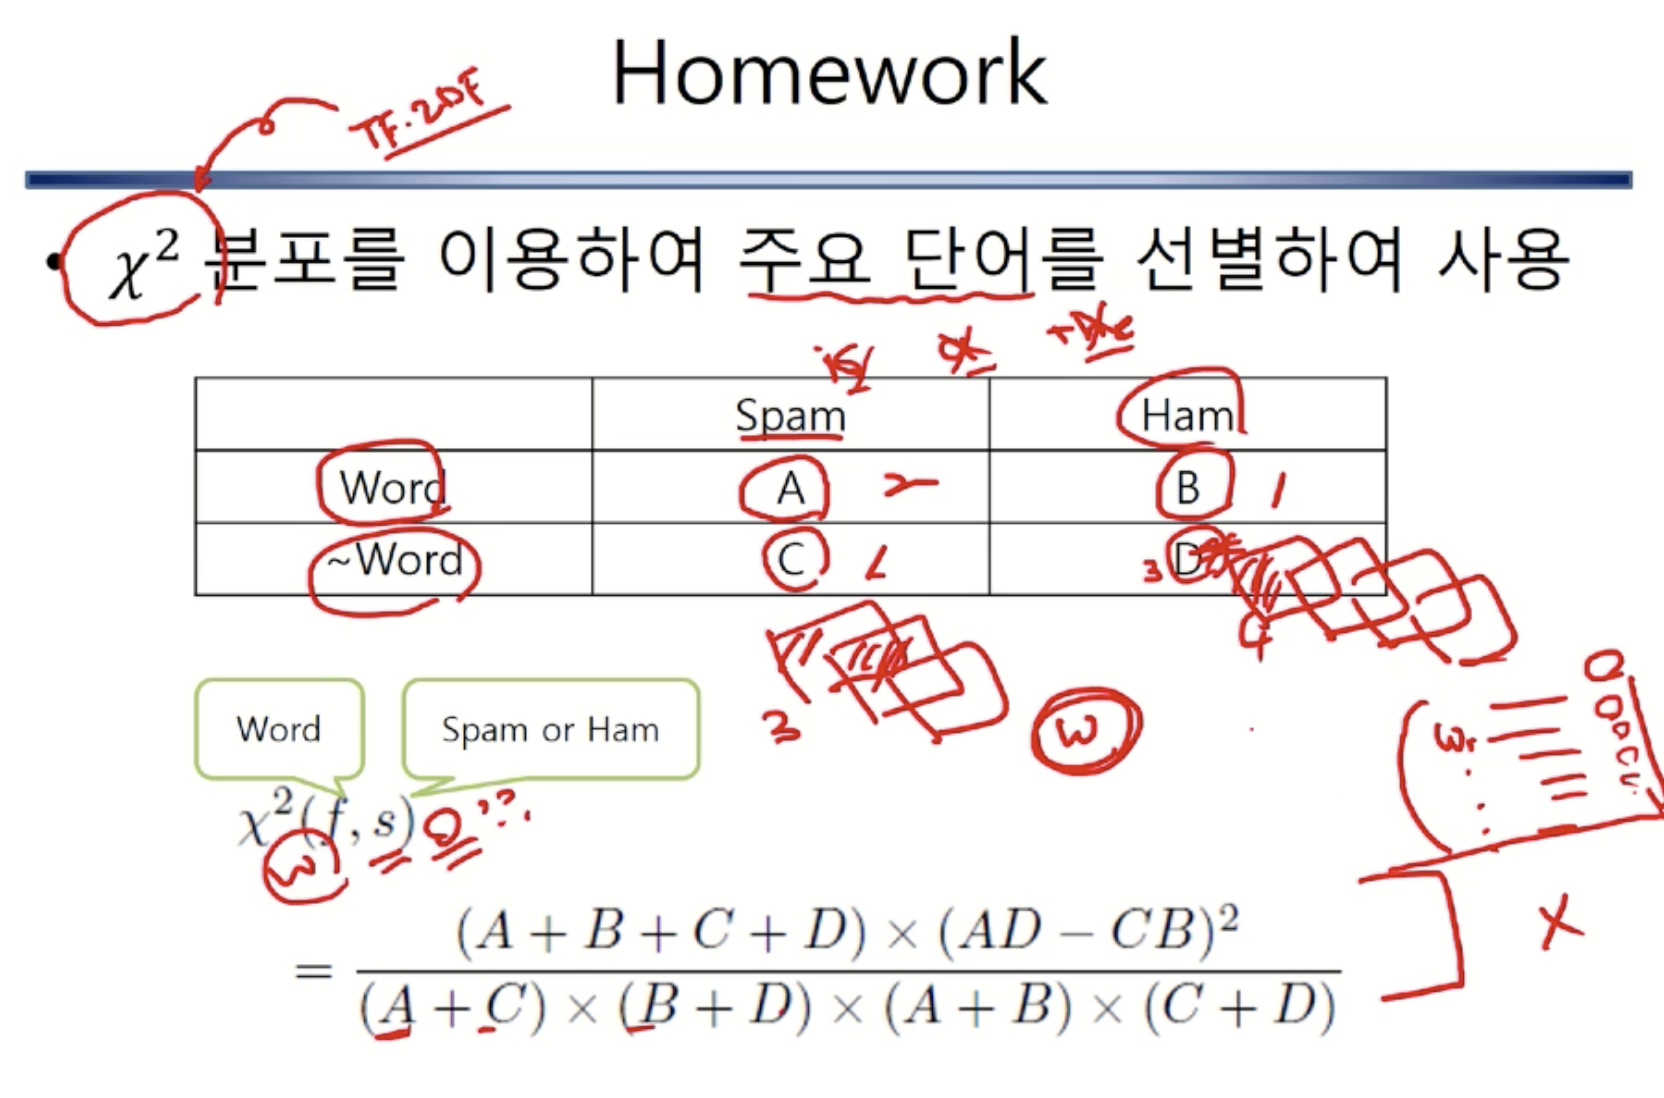

<h2>과제</h2>

<pre>
<b>1. 카이제곱 통계량을 이용하여 분류할 각 클래스와 관련된 단어를 추출</b>
  
  카이제곱 통계량 수식(w, c) = ( (A + B + C + D) x ((AD-BC) x (AD-BC)) ) / ( (A+B) x (A+C) x (B+D) x (C+D) )

  이 때, 
    A = 클래스 c에 대응하는 문서 중에서 단어 w를 포함하고 있는 문서의 수
    B = 클래스 c 이외의 문서 중에서 단어 w를 포함하고 있는 문서의 수
    C = 클래스 c에 속한 문서 중에서 단어 w를 포함하고 있지 않은 문서의 수
    D = 클래스 c 이외의 문서 중에서 단어 w를 포함하고 있지 않은 문서의 수

  이를 사용하여 계산한 카이제곱 점수를 내림차순으로 정렬하여 상위 n개의 단어 추출하여 클래스별 자질 사전 생성
 
</pre>

In [6]:
# ready
import pandas as pd
import numpy as np

import sys
np.set_printoptions(threshold=sys.maxsize)
import os
import tqdm
import warnings
warnings.filterwarnings(action='ignore')

from IPython.display import display
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# visualization
from matplotlib import pyplot as plt

In [7]:
# sklearn
from keras.preprocessing.text import Tokenizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

ModuleNotFoundError: No module named 'keras'

In [15]:
import re
import string
from nltk.corpus import stopwords  

### step1. Load data
spam 데이터를 가져온다. 라벨 \t 문장 형식이다.

In [9]:
# load 함수
data_dir = 'data'

def load_data(file_path):
  file = open(os.path.join(data_dir, file_path))

  texts, labels = [], []

  for line in file.readlines():
    pieces = line.strip().split('\t')
    label, text = pieces[0], pieces[1].lower()    # 소문자 변환
    labels.append(label)
    texts.append(text)

  # 특수문자 문자열 처리 
  texts = [i.translate(str.maketrans('','',string.punctuation)) for i in texts]

# data frame
  df = pd.DataFrame({'text':texts,'label':labels})

  return texts, labels, df

In [10]:
# data set
X,y,data = load_data('SMSSpamCollection')

# 확인
print(data.shape)
data.head()

(1500, 2)


,text,label
0,go until jurong point crazy available only in ...,ham
1,ok lar joking wif u oni,ham
2,free entry in 2 a wkly comp to win fa cup fina...,spam
3,u dun say so early hor u c already then say,ham
4,nah i dont think he goes to usf he lives aroun...,ham


In [11]:
# 확인
X[100]

'please dont text me anymore i have nothing else to say'

In [12]:
data['label'].value_counts()    # imbalanced 

ham     1285
spam     215
Name: label, dtype: int64

In [13]:
# 각 클래스별 대응하는 문서 분류
ham = data[data['label']=='ham']
spam = data[data['label']=='spam']

ham.shape, spam.shape

((1285, 2), (215, 2))

### step2. Tokenizing
단어를 띄어쓰기 단어로 문장별로 쪼개서 리스트에 저장한다.  
(이 후에 카이제곱 분포에 매핑해서 weight 구하는 임베딩 작업 예정)

In [16]:
processed_data = [[t for t in w.split()] for w in X if not w in stopwords.words('english')]
#processed_ham = [[t for t in sentence.split()] for sentence in ham.text.tolist()]
#processed_spam = [[t for t in sentence.split()] for sentence in spam.text.tolist()]

#precssed_data[:2]

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/Users/jinji/nltk_data'
    - '/Users/jinji/anaconda3/nltk_data'
    - '/Users/jinji/anaconda3/share/nltk_data'
    - '/Users/jinji/anaconda3/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


### step3. Word embedding  
카이제곱 분포에 매핑시켜서 단어별 스코어를 구한다.  

<b>1. 카이제곱 통계량을 이용하여 분류할 각 클래스와 관련된 단어를 추출</b>
  
  카이제곱 통계량 수식(w, c) = ( (A + B + C + D) x ((AD-BC) x (AD-BC)) ) / ( (A+B) x (A+C) x (B+D) x (C+D) )

  이 때,   
    A = 클래스 c 에 대응하는 문서 중에서 단어 w를 포함하고 있는 문서의 수  
    B = 클래스 c 이외의 문서 중에서 단어 w를 포함하고 있는 문서의 수  
    C = 클래스 c 에 속한 문서 중에서 단어 w를 포함하고 있지 않은 문서의 수  
    D = 클래스 c 이외의 문서 중에서 단어 w를 포함하고 있지 않은 문서의 수  

  이를 사용하여 계산한 카이제곱 점수를 내림차순으로 정렬하여 상위 n개의 단어 추출하여 클래스별 자질 사전 생성
 
</pre>

In [111]:
# ham
for ham_word in processed_data:
    A = len([True for t in processed_ham if t in ham_word])
    B = len([True for t in processed_spam if t in ham_word])
    C = len(processed_ham) - A
    D = len(processed_spam) - B
    
    chi_score = ((A+B+C+D)*((A*D-B*C)*(A*D-B*C))) / (((A+B)*(A+C)*(B+D)*(C+D))+0.00001)
    print(chi_score)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [80]:
ham_index = ham.index
ham_index

Int64Index([   0,    1,    3,    4,    6,    7,   10,   13,   14,   16,
            ...
            1489, 1490, 1491, 1493, 1494, 1495, 1496, 1497, 1498, 1499],
           dtype='int64', length=1285)

In [92]:
X[ham_index]

TypeError: list indices must be integers or slices, not Int64Index

In [89]:
# t는 토큰(단어),d는 문서(해당 문서 1개), D는 문장(문서)들
def chi_score(data,X,label):
    
    # 해당 클래스(label)의 문서
    class_doc = data.iloc[ham.index]
    notclass_doc = data.iloc[spam.index]
    
    print(class_doc)
    # tokenizing
    processed_data = [[t for t in sentence.split()] for sentence in X]
    
    # A = 클래스 c 에 대응하는 문서 중에서 단어 w를 포함하고 있는 문서의 수
    for d in processed_data:
        A = len([True for d in class_doc if t in d])
        B = len([True for d in notclass_doc if t in notclass_doc])
        C = len(class_doc) - A
        D = len(notclass_doc) - B

    return  ((A+B+C+D)*((A*D-B*C)*(A*D-B*C))) / ((A+B)*(A+C)*(B+D)*(C+D))

In [90]:
chi_score(data,X,'ham')

                                                   text label
0     go until jurong point crazy available only in ...   ham
1                               ok lar joking wif u oni   ham
3           u dun say so early hor u c already then say   ham
4     nah i dont think he goes to usf he lives aroun...   ham
6     even my brother is not like to speak with me t...   ham
...                                                 ...   ...
1495  it has everything to do with the weather keep ...   ham
1496  hey gals anyone of u going down to e driving c...   ham
1497  im always on yahoo messenger now just send the...   ham
1498  im putting it on now it should be ready for  l...   ham
1499  time n smile r the two crucial things in our l...   ham

[1285 rows x 2 columns]


TypeError: 'in <string>' requires string as left operand, not list

In [63]:
for t in processed_data[:5]:
    print(t)

['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'in', '2', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', '21st', 'may', '2005', 'text', 'fa', 'to', '87121', 'to', 'receive', 'entry', 'questionstd', 'txt', 'ratetcs', 'apply', '08452810075over18s']
['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say']
['nah', 'i', 'dont', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives', 'around', 'here', 'though']


In [64]:
chi_score(data,'ham')

KeyError: "None of [Int64Index([   0,    1,    3,    4,    6,    7,   10,   13,   14,   16,\n            ...\n            1489, 1490, 1491, 1493, 1494, 1495, 1496, 1497, 1498, 1499],\n           dtype='int64', length=1285)] are in the [columns]"

In [9]:
# 각각 단어 수 세기
from collections import Counter
freq_pos = Counter(pos_voca)
freq_neg = Counter(neg_voca)

pos = pd.DataFrame.from_dict(freq_pos,orient='index',columns=['tf'])
neg = pd.DataFrame.from_dict(freq_neg,orient='index',columns=['tf'])

pos.head()

,tf
제품,65
도,547
너무,129
맘,55
에,254


In [10]:
# idf 
# outer join 된 데이터 프레임에서 df 와 idf 를 만든다.
df = pd.merge(pos, neg, left_on = pos.index, right_on = neg.index, how='outer')
df.columns=['word','pos_tf','neg_tf']
df.head(10)

,word,pos_tf,neg_tf
0,제품,65.0,44.0
1,도,547.0,239.0
2,너무,129.0,92.0
3,맘,55.0,18.0
4,에,254.0,337.0
5,들,138.0,116.0
6,ㄴ답니다,2.0,1.0
7,좋,417.0,155.0
8,아요,168.0,84.0
9,통,11.0,33.0


In [11]:
# idf
df['df'] = df.iloc[:,1:3].notnull().sum(axis = 1)     # 단어가 나온 문서의 수
df['idf'] = np.log(2/df.df)      # n = 2
df = df.fillna(0)
df

,word,pos_tf,neg_tf,df,idf
0,제품,65.0,44.0,2,0.000000
1,도,547.0,239.0,2,0.000000
2,너무,129.0,92.0,2,0.000000
3,맘,55.0,18.0,2,0.000000
4,에,254.0,337.0,2,0.000000
...,...,...,...,...,...
2670,일주,0.0,1.0,1,0.693147
2671,물어니,0.0,1.0,1,0.693147
2672,그러면,0.0,1.0,1,0.693147
2673,건성,0.0,2.0,1,0.693147


In [12]:
# weight 구하기
pos_tfidf = pd.merge(pos,df['idf'],left_on = pos.index, right_on = df.word,how='left')
pos_tfidf['weight'] = pos_tfidf['tf']*pos_tfidf['idf']

neg_tfidf = pd.merge(neg,df['idf'],left_on = neg.index, right_on = df.word,how='left')
neg_tfidf['weight'] = neg_tfidf['tf']*neg_tfidf['idf']

# 긍정/부정 단어 각 상위 10개
print(pos_tfidf.sort_values(by=['weight'], axis=0, ascending=False).head(10))
print(neg_tfidf.sort_values(by=['weight'], axis=0, ascending=False).head(10))

     key_0  tf       idf    weight
93      적극  12  0.693147  8.317766
597    사용법  10  0.693147  6.931472
455      철  10  0.693147  6.931472
940     고민   9  0.693147  6.238325
375     강추   8  0.693147  5.545177
645     세심   5  0.693147  3.465736
762     여러   5  0.693147  3.465736
151      쏙   5  0.693147  3.465736
448  강추합니다   5  0.693147  3.465736
470     모습   4  0.693147  2.772589
     key_0  tf       idf     weight
396     짜증  24  0.693147  16.635532
714    하지만  23  0.693147  15.942385
167     더니  22  0.693147  15.249238
74     그런데  20  0.693147  13.862944
687     그것  19  0.693147  13.169796
68      다시  18  0.693147  12.476649
49      다만  17  0.693147  11.783502
1162    실망  15  0.693147  10.397208
484     라는  15  0.693147  10.397208
852     업체  13  0.693147   9.010913


각 문서 단어의 weight 값을 확인 후 weight 값이 바뀌는 적당한 곳에서 절사했다.   
긍정은 79개, 부정은 88개가 된다.

In [13]:
# 긍정/부정 단어 상위 100개씩 추출
pos100 = pos_tfidf.sort_values(by=['weight'], axis=0, ascending=False)[pos_tfidf['weight']>1].key_0.tolist()
neg100 = neg_tfidf.sort_values(by=['weight'], axis=0, ascending=False)[neg_tfidf['weight']>3].key_0.tolist()

# 각 단어리스트 확인
print('긍정',pos100)
print('부정',neg100)

# 긍정 부정 train data set 을 만든다.
train = pd.DataFrame(pos100+neg100)
train['label'] = 0
train['label'][:len(pos100)+1] = '<P>'
train['label'][len(pos100):] = '<N>'

X_train_ = train.iloc[:,0]
y_train_ = train.iloc[:,1]

긍정 ['적극', '사용법', '철', '고민', '강추', '세심', '여러', '쏙', '강추합니다', '모습', '좋구여', '가격싸고', '배려', '강추입니다', '기숙사', '강추예요', '어른', '당근', '전기', '베리', '가르치', '훌륭', '전용', '신속', '완벽', '부자', '행복', '잔', '제일', '굳이', '울', '넉넉', '나이드신', '강츄', '저렵', '섬유유연제가', '구조', '외부', '우', '시장', '이서', '쿠폰', '땀', '강추에요', '애기', '욕실', '상쾌', '바', '지르', '주정', '에다', '맞히', '불경기', '기원', '찾', '꼼꼼', '기쁘', '역', '사도', '공기방울', '중요', '안심', '효율', '대단히', '사시', '화면', '폐가', '굳', '작동법', '화이트', '구김', '국산', '장마철', '독신자', '주신', '뒤지', '외관', '하하', '관리법', '버튼', '엉킴도', '혼자사니깐딱인거같아요', '튼튼', '사고', '새해', '시험', '오히려', '생활']
부정 ['짜증', '하지만', '더니', '그런데', '그것', '다시', '다만', '실망', '라는', '업체', '그런', '언제', '취소', '시끄럽', '소비자', '문', '지연', '쯤', '나쁘', '장난', '태도', '습니까', '아쉽', '한테', '다면', '원래', '무슨', '어쩌', '얘기', '단점', '보내', '아무래도', '사실', '열', '밤', '어렵', '실', '다행', '소', '교환', '문의', '냐고', '약하', '몇일', '냐', '성의', '결제', '대충', '야', '그거', '아닌가요', '반품', '당일', '호스', 'ㅂ니까', '기본', '상하', '자체', '토요일', '목', '질문', '한가지', '재고', '저녁', '똑같', '배송만', '따로', '그러나', '조절', '휴', '쪽', '심'

### step4. Naive Bayes

In [14]:
# 새로운 단어사전에 fitting
vectorizer = CountVectorizer()
feature_X_train = vectorizer.fit_transform(X_train_)
feature_X_test = vectorizer.transform(X_test)

In [15]:
# train
clf = MultinomialNB()
clf.fit(feature_X_train, y_train_)

# prediction
y_pred = clf.predict(feature_X_test)

# evaluate score
print('Accuracy : %.2f'% accuracy_score(y_test,y_pred))

Accuracy : 0.66


### 비교 : Sklearn TfidfVectorizer 구현체

In [16]:
vectorizer = TfidfVectorizer()

feature_X_train = vectorizer.fit_transform(X_train)
feature_X_test = vectorizer.transform(X_test)

In [17]:
# train
clf = MultinomialNB()
clf.fit(feature_X_train, y_train)

# prediction
y_pred = clf.predict(feature_X_test)

# evaluate score
print('Accuracy : %.2f'% accuracy_score(y_test,y_pred))

Accuracy : 0.84


tf idf 를 구하고 긍정/부정 단어들이 있는 단어사전을 만들고 fitting 시키는 과정이   
1주차 과제를 스스로 참고했다고하나 거의 하드 코딩이었다. 
사이킷런 구현체를 쓰지 않으면서도 쉽게 사전을 만드는 방법이 있을 것 같은데 못찾았다.  
또한 겹치는 단어를 tf idf 가 최대한 걸러내기를 바랬으나, 겹치는 단어가 있어서 Accuracy는 사이킷런보다 20퍼센트 낮은 0.66에 그친다.